In [1]:
import json
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import ClassicalRegister, QuantumRegister
from qiskit import QuantumCircuit
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import RealAmplitudes
from qiskit.quantum_info import Statevector
from qiskit.utils import algorithm_globals

from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit_machine_learning.neural_networks import SamplerQNN

#set seed for pseudorandom number generator
algorithm_globals.random_seed = 42

/tmp/ipykernel_34984/3267144248.py:10: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import COBYLA
/tmp/ipykernel_34984/3267144248.py:19: DeprecationWarning: The property ``qiskit.utils.algorithm_globals.QiskitAlgorithmGlobals.random_seed`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. This algorithm utility has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. You can run ``pip install qiskit_algorithms`` and import ``from qiskit_algorithms.utils`` instead. 
  algorithm_globals.random_seed = 42


In [2]:
def AnsatzBuilder(QubitNumber, Depth):
    return RealAmplitudes(QubitNumber, reps=Depth)

In [34]:
def SwaptestBuilder(InputStateDimension, TrashQubitNumber):
    QubitNumber = InputStateDimension + TrashQubitNumber + 1
    QuantReg = QuantumRegister(QubitNumber)
    ClassReg = ClassicalRegister(1)
    SwaptestCircuit = QuantumCircuit(QuantReg, ClassReg)
    AuxilaryQubitLable = InputStateDimension+TrashQubitNumber #+1 (for auxiliary qubit) -1 (because of 0 indexing)
    
    #H GATE ON AUXILIARY QUBIT
    SwaptestCircuit.h(AuxilaryQubitLable)
    #CSWAP GATES BETWEEN TRASH AND REFERENCE QUBITS TARGETING AUXILIARY QUBIT
    for i in range(TrashQubitNumber):
        SwaptestCircuit.cswap(i, InputStateDimension-TrashQubitNumber+i, InputStateDimension+i)
    #H GATE ON AUXILIARY QUBIT
    SwaptestCircuit.h(AuxilaryQubitLable)
    SwaptestCircuit.measure(AuxilaryQubitLable, ClassReg[0])

    return SwaptestCircuit


In [31]:
def EncoderBuilder(InputStateDimension, EncodedStateDimension, Depth):
    #Calculate dimension of spaces
    LatentSpaceDimension = EncodedStateDimension
    TrashSpaceDimension = InputStateDimension - EncodedStateDimension
    ReferenceSpaceDimension = TrashSpaceDimension
    TotalQubitNumber = LatentSpaceDimension + TrashSpaceDimension + ReferenceSpaceDimension +1 #+1 (for auxiliary qubit)

    #Initialize circuit
    QuantReg = QuantumRegister(TotalQubitNumber,"q")
    ClassReg = ClassicalRegister(1,"c")
    Circuit = QuantumCircuit(QuantReg, ClassReg)

    #Add AnsatzCircuit
    #Circuit.compose(AnsatzBuilder(InputStateDimension, Depth),range(0, InputStateDimension), inplace=True)
    #Barrier to define optimization regions
    #FullCircuit.barrier()
    #Add SwapTestCircuit
    #FullCircuit.compose(SwaptestBuilder(InputStateDimension, TrashQubitNumber),range(0, QubitNumber+1), inplace=True)
    
    return Circuit


Print AnsatzCircuit

/home/codespace/.python/current/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


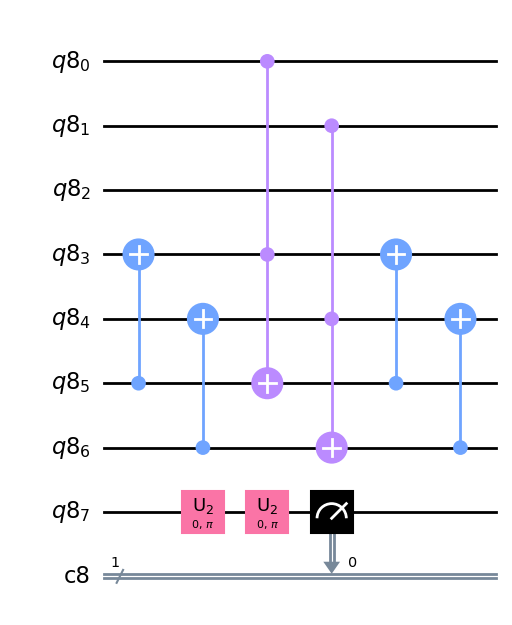

In [35]:
Swaptest = SwaptestBuilder(5,2)
Swaptest.decompose().draw("mpl")

Print Encoder

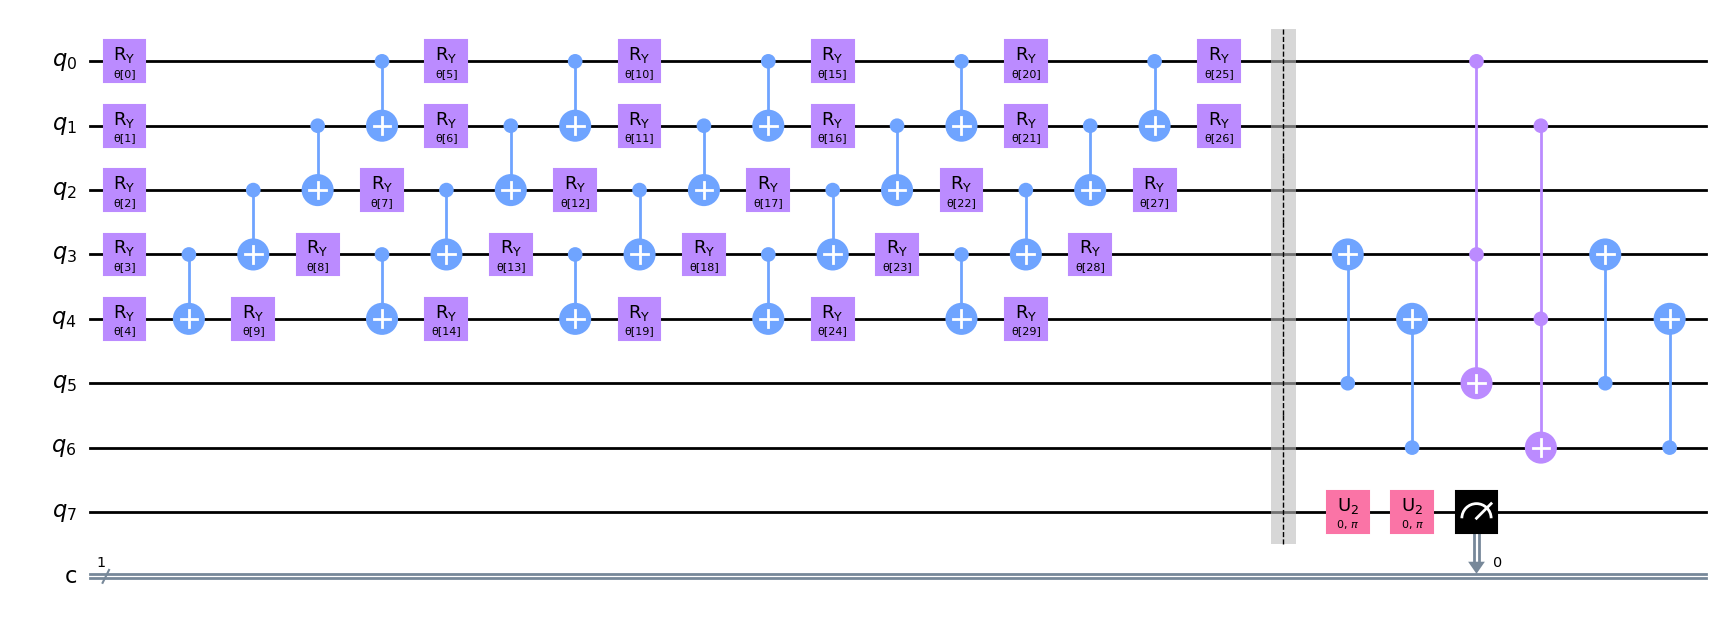

In [36]:
Encoder = EncoderBuilder(5,3,5)
Encoder.decompose().draw("mpl")

In [3]:

#define 
def auto_encoder_circuit(num_latent, num_trash):
    qr = QuantumRegister(num_latent + 2 * num_trash + 1, "q")
    cr = ClassicalRegister(1, "c")
    circuit = QuantumCircuit(qr, cr)
    circuit.compose(ansatz(num_latent + num_trash), range(0, num_latent + num_trash), inplace=True)
    circuit.barrier()
    auxiliary_qubit = num_latent + 2 * num_trash
    # swap test
    circuit.h(auxiliary_qubit)
    for i in range(num_trash):
        circuit.cswap (auxiliary_qubit, num_latent + i, num_latent + num_trash + i)

    circuit.h(auxiliary_qubit)
    circuit.measure(auxiliary_qubit, cr[0])
    return circuit

/tmp/ipykernel_5315/3609598157.py:2: DeprecationWarning: The property ``qiskit.utils.algorithm_globals.QiskitAlgorithmGlobals.random_seed`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. This algorithm utility has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. You can run ``pip install qiskit_algorithms`` and import ``from qiskit_algorithms.utils`` instead. 
  algorithm_globals.random_seed = 42


/home/codespace/.python/current/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


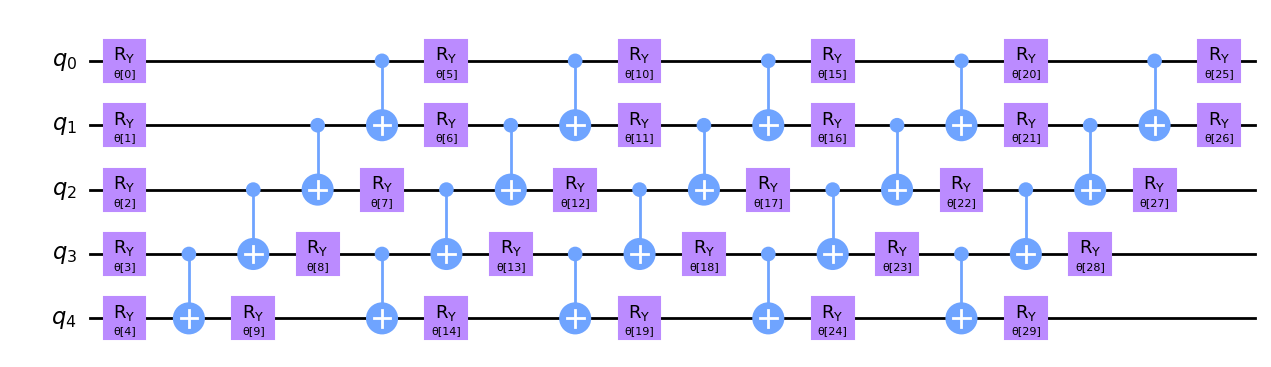

In [4]:
num_qubits = 5
circ = ansatz(num_qubits)
circ.decompose().draw("mpl")

/home/codespace/.python/current/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


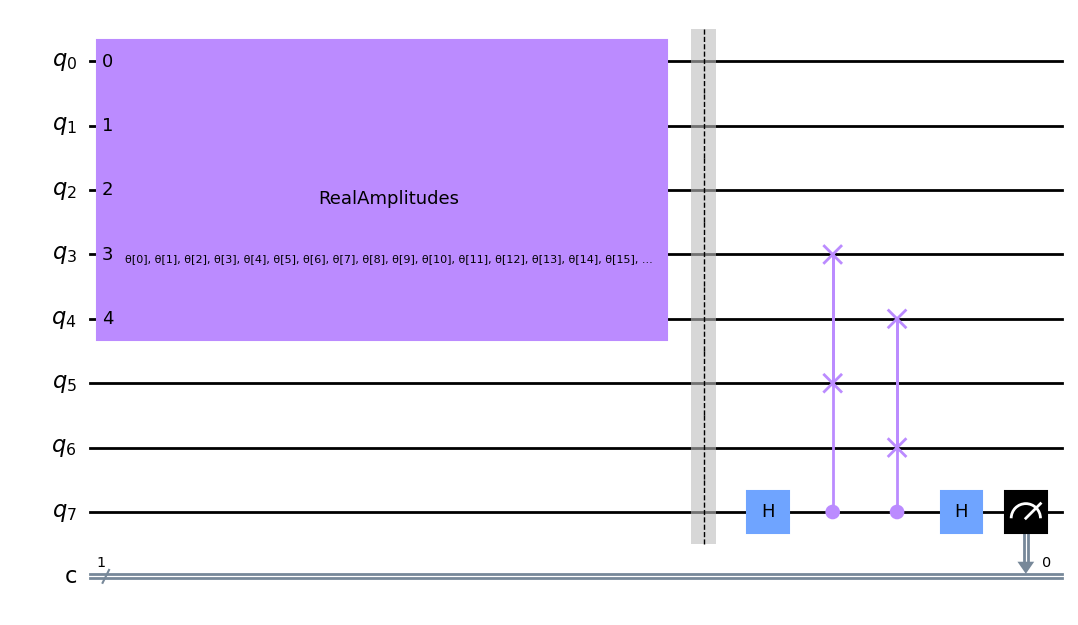

In [5]:
num_latent = 3
num_trash = 2
circuit = auto_encoder_circuit(num_latent, num_trash)
circuit.draw("mpl")